In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from __future__ import print_function
import keras
from keras import backend as K
from keras import layers, models
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.layers import LSTM#, sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator as ImgDataGen
from keras.preprocessing.image import img_to_array, load_img
from keras.regularizers import l2
from keras.models import Model
from keras.models import load_model
#-   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasRegressor
#-   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
from sklearn.model_selection import ShuffleSplit, train_test_split
#-   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
import glob
import cv2
#-   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
import pydot
#-   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
import matplotlib.pyplot as plt
import h5py
#-   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
import warnings
warnings.filterwarnings("ignore")
#-   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from PIL import Image

In [0]:
path 			= r'/content/gdrive/My Drive/ML Project/Baseball Faces'
os.chdir(path)
seed 			= 7
np.random.seed(seed)
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [0]:
i 			= 0 #Revision Count
K.set_image_dim_ordering('th')

'Dataset PreProcessing'
df 			= pd.read_csv('Train.csv')
df['Image_Name'] 	= df['Image_Name'] + '.jpg'
'----'
test_size 		= 0.20
val_size 		= 0.20
df_trn, df_tst 		= train_test_split(df, test_size=test_size, random_state=seed)
df_subtrn, df_val 	= train_test_split(df_trn, test_size=val_size, random_state=seed)
'----'
num_classes 		= 2
target_feature 		= ['Competency_Score','Trustworthy_Score']
'Flow Parameters'
img_height         	= 128
img_width          	= 85
img_channels 		= 3
reshapeSize        	= (img_width, img_height)
input_shape 		= (img_channels,img_width,img_height)
cardinality 		= 32
data_augmentation 	= True
subtract_pixel_mean 	= True # Subtracting pixel mean improves accuracy
'Generator Parameters'
validationSplit 	= 0.2
rescale 		= (1./255.)
normalization 		= True
xColName               	= 'Image_Name'
yColName	   	= ['Competency_Score','Trustworthy_Score'] 	                                #'Competency_Score'
batch_size 		= 32  	                                                # orig paper trained all networks with batch_size=128
interpolationMethod 	= 'nearest'                                             #Interpolation method used to resample the image if the target size is different from that of the loaded image.Supported methods are `"nearest"`, `"bilinear"`, and `"bicubic"`
'----'
dataType 		= 'float32'
shuffle 		= True
class_mode 		= 'other'
inputDirectory     	= './TrainPictures'
outputDirectory    	= './AugmentedPics/rev1'
color_mode 	 	= "rgb"
has_ext 		= False
'Training parameters'
n 			= 1
depth 			= n * 9 + 2 # depth (int): number of core convolutional layers
version 		= 2
'Compiling Parameters'
loss 			= 'mean_squared_error'
preformanceMetric	= 'mae'                                             #'mae  mean absolute error 	 	 	 	'accuracy'
optimizer 		= 'Adam(lr=lr_schedule(0))' #not automated, just a placeholder!
'Fitting Parameters'
epochs 			= 20
learning_rate 		= 0.01
steps_per_epoch 	= df_subtrn.shape[0] // batch_size                         #'steps_per_epoch'
valStepsPerEpoch 	= df_val.shape[0] // batch_size
tstStepsPerEpoch 	= len(df_tst)
'Residual Block Parameters'
first_num_filters_in	= 9 
resBlockActivationFn 	= 'relu'
denseActivationFn 	= 'linear'
denseKernelInitializer 	= 'he_normal'
'Residual Layers Parameters'
resLayerFilterNo 	= 9
resLayerKernelSize 	= 3
resLayerStrides 	= 1
resLayerActivation 	= 'relu'
batch_normalization 	= True
convLayerPadding 	= 'same'
convKernelInitializer 	= 'he_normal' # https://keras.io/initializers/
convKernelRegularizer 	= l2(1e-4)
'Visuals'
RevNo 		= i + 1
model_type 	= 'ResNet_Rev %dv%d' % (RevNo, depth) 

Learning rate:  0.01
Found 512 images.
Found 128 images.
Found 160 images.
Epoch 1/20
Learning rate:  0.01
16/16 [==============================] - 25s 2s/step - loss: 7.1408 - mean_absolute_error: 1.9816 - val_loss: 6.2171 - val_mean_absolute_error: 2.0591

Epoch 00001: val_mean_absolute_error improved from inf to 2.05908, saving model to /content/gdrive/My Drive/ML Project/Baseball Faces/saved_models/ResNet_ResNet_Rev 1v11_model.001.h5
Epoch 2/20
Learning rate:  0.01
16/16 [==============================] - 1s 73ms/step - loss: 3.9972 - mean_absolute_error: 1.5831 - val_loss: 5.7472 - val_mean_absolute_error: 1.9707

Epoch 00002: val_mean_absolute_error improved from 2.05908 to 1.97070, saving model to /content/gdrive/My Drive/ML Project/Baseball Faces/saved_models/ResNet_ResNet_Rev 1v11_model.002.h5
Epoch 3/20
Learning rate:  0.01
16/16 [==============================] - 1s 68ms/step - loss: 3.8349 - mean_absolute_error: 1.5429 - val_loss: 4.8234 - val_mean_absolute_error: 1.7775

E

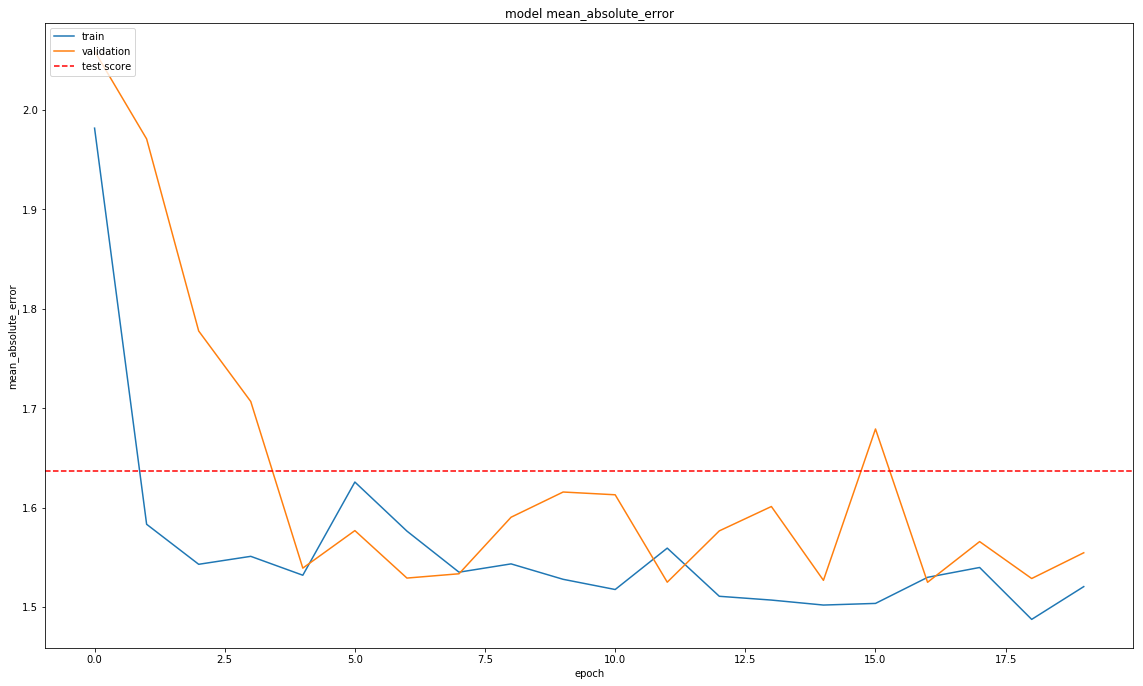

'# "Loss" --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- -'

In [0]:
def lr_schedule(epoch):

    lr = learning_rate
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def resnet_layer(inputs,
                 num_filters = resLayerFilterNo,
                 kernel_size = resLayerKernelSize,
                 strides = resLayerStrides,
                 activation = resLayerActivation,
                 batch_normalization = batch_normalization,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding=convLayerPadding,
                  kernel_initializer = convKernelInitializer,
                  kernel_regularizer = convKernelRegularizer)

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v2(input_shape, depth, num_classes = num_classes):
	    if (depth - 2) % 9 != 0:
		    raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
	    
	    # Start model definition.
	    num_filters_in = first_num_filters_in
	    num_res_blocks = int((depth - 2) / 9)
	
	    inputs = Input(shape=input_shape)
	    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
	    x = resnet_layer(inputs=inputs,
	                     num_filters=num_filters_in,
	                     conv_first=True)
	
	    # Instantiate the stack of residual units
	    for stage in range(3):
	        for res_block in range(num_res_blocks):
	            activation = 'relu'
	            batch_normalization = True
	            strides = 1
	            if stage == 0:
	                num_filters_out = num_filters_in * 4
	                if res_block == 0:  	 	 	 	 	# first layer and first stage
	                    activation = None
	                    batch_normalization = False
	            else:
	                num_filters_out = num_filters_in * 2
	                if res_block == 0:  # first layer but not first stage
	                    strides = 2    # downsample
	
	            # bottleneck residual unit
	            y = resnet_layer(inputs=x,
	                             num_filters=num_filters_in,
	                             kernel_size=1,
	                             strides=strides,
	                             activation=activation,
	                             batch_normalization=batch_normalization,
	                             conv_first=False)
	            y = resnet_layer(inputs= y,
	                             num_filters=num_filters_in,
	                             conv_first=False)
	            y = resnet_layer(inputs=y,
	                             num_filters=num_filters_out,
	                             kernel_size=1,
	                             conv_first=False)
	            if res_block == 0:
	                # linear projection residual shortcut connection to match
	                # changed dims
	                x = resnet_layer(inputs=x,
	                                 num_filters=num_filters_out,
	                                 kernel_size=1,
	                                 strides=strides,
	                                 activation=None,
	                                 batch_normalization=False)
	            x = keras.layers.add([x, y])
	
	        num_filters_in = num_filters_out
	
	    # Add classifier on top.
	    # v2 has BN-ReLU before Pooling
	    x = BatchNormalization()(x)
	    x = Activation('relu')(x)
	    x = AveragePooling2D(pool_size=8)(x)
	    y = Flatten()(x)
	    outputs = Dense(num_classes,
	                    activation 			= denseActivationFn,
	                    kernel_initializer 		= denseKernelInitializer)(y)
	
	    # Instantiate model.
	    model = Model(inputs=inputs, outputs=outputs)
	    return model
				    
model = resnet_v2(input_shape=input_shape, depth=depth)

model.compile(loss = loss, optimizer = Adam(lr=lr_schedule(0)), metrics = [preformanceMetric])
# model.summary()

model_name = 'ResNet_%s_model.{epoch:03d}.h5' % model_type
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
# =============================================================================
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_mean_absolute_error',
                             verbose=1,
                             save_best_only=True,
                             mode = 'min')
# =============================================================================

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler, checkpoint] #checkpoint, 
'# Image PreProcessing ########################################################'
'#%% configuring data-generators'
# https://keras.io/preprocessing/image/
dg_subtrn 	= ImgDataGen(rescale= rescale,\
			validation_split= validationSplit,\
			dtype = dataType,\
			featurewise_std_normalization = normalization)
dg_tst  	= ImgDataGen(rescale= rescale,\
		      dtype = dataType,\
		      featurewise_std_normalization = normalization)
'# PreProcessing Training Dataset '
df_subtrn = dg_subtrn.flow_from_dataframe(dataframe = df_trn,\
				  directory = inputDirectory,\
				  x_col = xColName,\
				  y_col = yColName,\
				  batch_size = batch_size,\
				  seed = seed,\
				  shuffle = True,\
				  color_mode = color_mode,\
				  class_mode = class_mode,\
				  target_size = reshapeSize,\
				  has_ext = has_ext,\
				  subset = 'training',\
				  interpolation = interpolationMethod)#,\save_to_dir = outputDirectory)
'# PreProcessing Validation Dataset'
df_val = dg_subtrn.flow_from_dataframe(dataframe = df_trn,\
					directory = inputDirectory,\
					x_col = xColName,\
					y_col= yColName,\
					batch_size = batch_size,\
					seed = seed,\
					shuffle = True,\
					color_mode = color_mode,\
					class_mode = class_mode,\
					target_size = reshapeSize,\
					has_ext = has_ext,\
					subset = 'validation',\
					interpolation = interpolationMethod)
'# PreProcessing Test Dataset '
df_tst = dg_tst.flow_from_dataframe(dataframe = df_tst,\
					directory=inputDirectory,\
					x_col= xColName,\
					y_col= yColName,\
					batch_size=batch_size,\
					seed = seed,\
					shuffle=shuffle,\
					has_ext = has_ext,\
					class_mode=class_mode,\
					target_size=reshapeSize,\
					interpolation = interpolationMethod)
'#%% Fitting Model ############################################################'
history = model.fit_generator(df_subtrn,\
                              steps_per_epoch = steps_per_epoch,\
                              epochs = epochs,\
                              validation_data = df_val,\
                              validation_steps = valStepsPerEpoch,\
                              callbacks = callbacks)
'#%% Model Predictions ########################################################'
mae_tst = model.evaluate_generator(generator= df_tst, steps= tstStepsPerEpoch)
'Visuals --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- '
# model.summary()
print(model_type)
#-   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
plot_model(model, to_file='./model_plot.png',\
	   show_shapes=True,\
	   show_layer_names=True,\
	   rankdir='LR')

'#  "mean_absolute_error" '
fig = plt.gcf()
fig.set_size_inches(19.5, 11.5)
fig.show()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.axhline(y=mae_tst[1], color='r', linestyle='--')
# -- -- -- --
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'validation','test score'], loc='upper left')
plt.show()
fig.savefig('model_learning_'+str(learning_rate)+'.png')

# fig.savefig('test2png.png', dpi=100)
'--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ------ --- ---'

'# "Loss" --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- -'
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#model.metrics_names

## TestSample Outputs

In [0]:
'''
In TestSamples.csv, I added the ['Competency_Score', 'Trustworthy_Score'] columns to avoid errors.

I also saved the new images in a folder named 'New Data'
'''

df_tst = pd.read_csv('/content/gdrive/My Drive/ML Project/Baseball Faces/TestSamples.csv')
df_tst['Image_Name'] 		= df_tst['Image_Name'] + '.jpg'

dg_tst  					= ImgDataGen(rescale = 1./255.)

y_col_2 = ['Competency_Score', 'Trustworthy_Score']

df_tst = dg_tst.flow_from_dataframe(dataframe = df_tst,\
										directory="/content/gdrive/My Drive/ML Project/Baseball Faces/New Data/",\
										x_col="Image_Name",\
										y_col= y_col_2,\
										batch_size=batch_size,\
										seed=42,\
										shuffle=False,\
										class_mode="other",\
										target_size=(85,128))




Found 133 images.


In [0]:
bestResNet_model = load_model('/content/gdrive/My Drive/ML Project/Baseball Faces/saved_models/ResNet_ResNet_Rev 1v11_model.017.h5')

pred = bestResNet_model.predict_generator(df_tst, steps= len(df_tst), verbose=1)
#met_test = best_model.evaluate_generator(generator= df_tst, steps= len(df_tst))
print(pred)

5/5 [==============================] - 17s 3s/step
[[6.2042584 6.197312 ]
 [6.52346   6.4579215]
 [6.0157833 6.1025066]
 [6.635904  6.6552696]
 [6.9143834 6.991422 ]
 [6.6353564 6.4453025]
 [5.8822865 6.0203695]
 [6.2594695 6.259927 ]
 [6.454761  6.3343554]
 [6.4934993 6.491546 ]
 [6.3351636 6.3565054]
 [6.101903  6.1483407]
 [6.2636538 6.353495 ]
 [5.851607  5.9139576]
 [5.8175874 5.794751 ]
 [6.3090134 6.365649 ]
 [5.81105   5.944595 ]
 [6.181627  6.180238 ]
 [6.364751  6.5383954]
 [6.2385445 6.1667776]
 [6.137221  6.2027216]
 [6.3269653 6.264406 ]
 [6.3283987 6.1621056]
 [6.2778964 6.2337966]
 [6.701177  6.671685 ]
 [5.928001  5.877136 ]
 [5.8640018 5.891138 ]
 [6.51593   6.283956 ]
 [6.46482   6.4015017]
 [6.218244  6.1413617]
 [6.0713573 6.0411277]
 [5.9308777 5.914034 ]
 [6.5209374 6.4812517]
 [6.6639237 6.582231 ]
 [6.4498267 6.536094 ]
 [6.613342  6.429268 ]
 [5.837134  5.7469406]
 [6.537803  6.471628 ]
 [6.228969  6.31975  ]
 [6.6059146 6.6052837]
 [6.0020337 6.0139256]
 [6.32